In [ ]:
import warnings
warnings.filterwarnings("ignore")

!pip install --upgrade category_encoders
!pip install catboost
!pip install optuna

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import OneHotEncoder, CatBoostEncoder, MEstimateEncoder
from sklearn.model_selection import StratifiedGroupKFold

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression

from sklearn import set_config
import os
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import StratifiedKFold
import optuna
from sklearn.compose import ColumnTransformer
from prettytable import PrettyTable

from sklearn.compose import make_column_transformer
from sklearn.base import clone
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import accuracy_score
import optuna
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.4 MB/s eta 0:00:00


In [ ]:
# Set Prameters for Reproduciblity
pd.set_option("display.max_rows",100)
FILE_PATH = "/content/"
TARGET = "NObeyesdad"
n_splits = 10
RANDOM_SEED = 43

In [ ]:
# load all data
!unzip playground-series-s4e2.zip
!unzip Dataset.zip
train = pd.read_csv(os.path.join(FILE_PATH, "train.csv"))
test = pd.read_csv(os.path.join(FILE_PATH, "test.csv"))
sample_sub = pd.read_csv(os.path.join(FILE_PATH, "sample_submission.csv"))
train_org = pd.read_csv("/content/ObesityDataSet.csv")

Archive:  playground-series-s4e2.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
Archive:  Dataset.zip
replace ObesityDataSet.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
def prettify_df(df):
    table = PrettyTable()
    table.field_names = df.columns

    for row in df.values:
        table.add_row(row)
    print(table)

In [ ]:
train.head(10)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
5,5,Male,18.128249,1.748524,51.552595,yes,yes,2.919751,3.000000,Sometimes,no,2.137550,no,1.930033,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
6,6,Male,29.883021,1.754711,112.725005,yes,yes,1.991240,3.000000,Sometimes,no,2.000000,no,0.000000,0.696948,Sometimes,Automobile,Obesity_Type_II
7,7,Male,29.891473,1.750150,118.206565,yes,yes,1.397468,3.000000,Sometimes,no,2.000000,no,0.598655,0.000000,Sometimes,Automobile,Obesity_Type_II
8,8,Male,17.000000,1.700000,70.000000,no,yes,2.000000,3.000000,Sometimes,no,3.000000,yes,1.000000,1.000000,no,Public_Transportation,Overweight_Level_I
9,9,Female,26.000000,1.638836,111.275646,yes,yes,3.000000,3.000000,Sometimes,no,2.632253,no,0.000000,0.218645,Sometimes,Public_Transportation,Obesity_Type_III


In [ ]:
# Train Data
print("Train Data")
print(f"Total number of rows: {len(train)}")
print(f"Total number of columns: {train.shape[1]}\n")

# Test Data
print("Test Data")
print(f"Total number of rows: {len(test)}")
print(f"Total number of columns:{test.shape[1]}")

Train Data
Total number of rows: 20758
Total number of columns: 18

Test Data
Total number of rows: 13840
Total number of columns:17


In [ ]:
# check null and unique count
# FHWO: family_history_with_overweight
train_copy = train.rename(columns={"family_history_with_overweight":"FHWO"})
tmp = pd.DataFrame(index=train_copy.columns)
tmp['count'] = train_copy.count()
tmp['dtype'] = train_copy.dtypes
tmp['nunique'] = train_copy.nunique()
tmp['%nunique'] = (tmp['nunique']/len(train_copy))*100
tmp['%null'] = (train_copy.isnull().sum()/len(train_copy))*100
tmp['min'] = train_copy.min()
tmp['max'] = train_copy.max()
tmp

tmp.reset_index(inplace=True)
tmp = tmp.rename(columns = {"index":"Column Name"})
tmp = tmp.round(3)
prettify_df(tmp)
del tmp, train_copy

+-------------+-------+---------+---------+----------+-------+---------------------+---------------------+
| Column Name | count |  dtype  | nunique | %nunique | %null |         min         |         max         |
+-------------+-------+---------+---------+----------+-------+---------------------+---------------------+
|      id     | 20758 |  int64  |  20758  |  100.0   |  0.0  |          0          |        20757        |
|    Gender   | 20758 |  object |    2    |   0.01   |  0.0  |        Female       |         Male        |
|     Age     | 20758 | float64 |   1703  |  8.204   |  0.0  |         14.0        |         61.0        |
|    Height   | 20758 | float64 |   1833  |   8.83   |  0.0  |         1.45        |       1.975663      |
|    Weight   | 20758 | float64 |   1979  |  9.534   |  0.0  |         39.0        |      165.057269     |
|     FHWO    | 20758 |  object |    2    |   0.01   |  0.0  |          no         |         yes         |
|     FAVC    | 20758 |  object |    

In [ ]:
raw_num_cols = list(train.select_dtypes("float").columns)
raw_cat_cols = list(train.columns.drop(raw_num_cols+[TARGET]))

full_form = dict({'FAVC' : "Frequent consumption of high caloric food",
                  'FCVC' : "Frequency of consumption of vegetables",
                  'NCP' :"Number of main meal",
                  'CAEC': "Consumption of food between meals",
                  'CH2O': "Consumption of water daily",
                  'SCC':  "Calories consumption monitoring",
                  'FAF': "Physical activity frequency",
                  'TUE': "Time using technology devices",
                  'CALC': "Consumption of alcohol" ,
                  'MTRANS' : "Transportation used"})

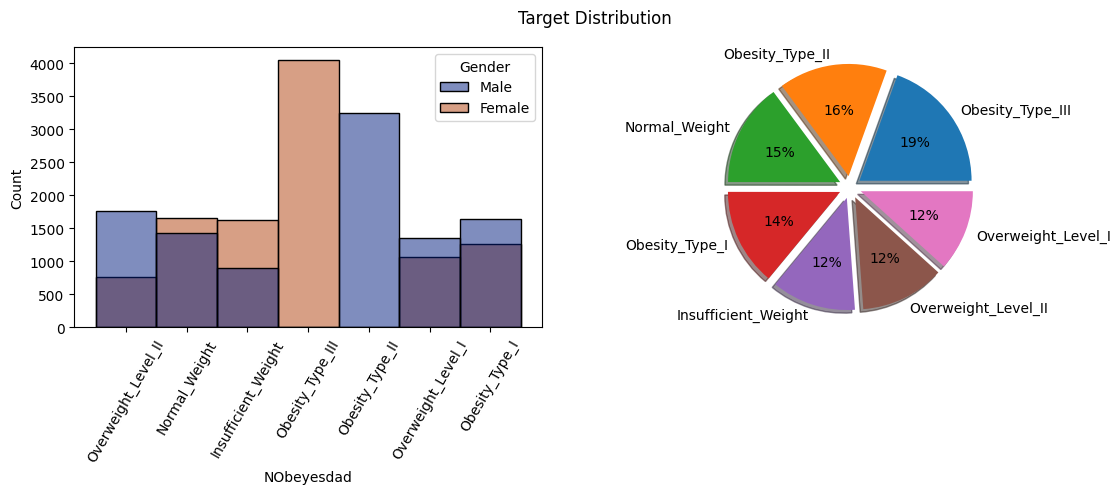

In [ ]:
fig, axs = plt.subplots(1,2,figsize = (12,5))
plt.suptitle("Target Distribution")

sns.histplot(binwidth=0.5,x=TARGET,data=train,hue='Gender',palette="dark",ax=axs[0],discrete=True)
axs[0].tick_params(axis='x', rotation=60)

axs[1].pie(
        train[TARGET].value_counts(),
        shadow = True,
        explode=[.1 for i in range(train[TARGET].nunique())],
        labels = train[TARGET].value_counts().index,
        autopct='%1.f%%',
    )

plt.tight_layout()
plt.show()

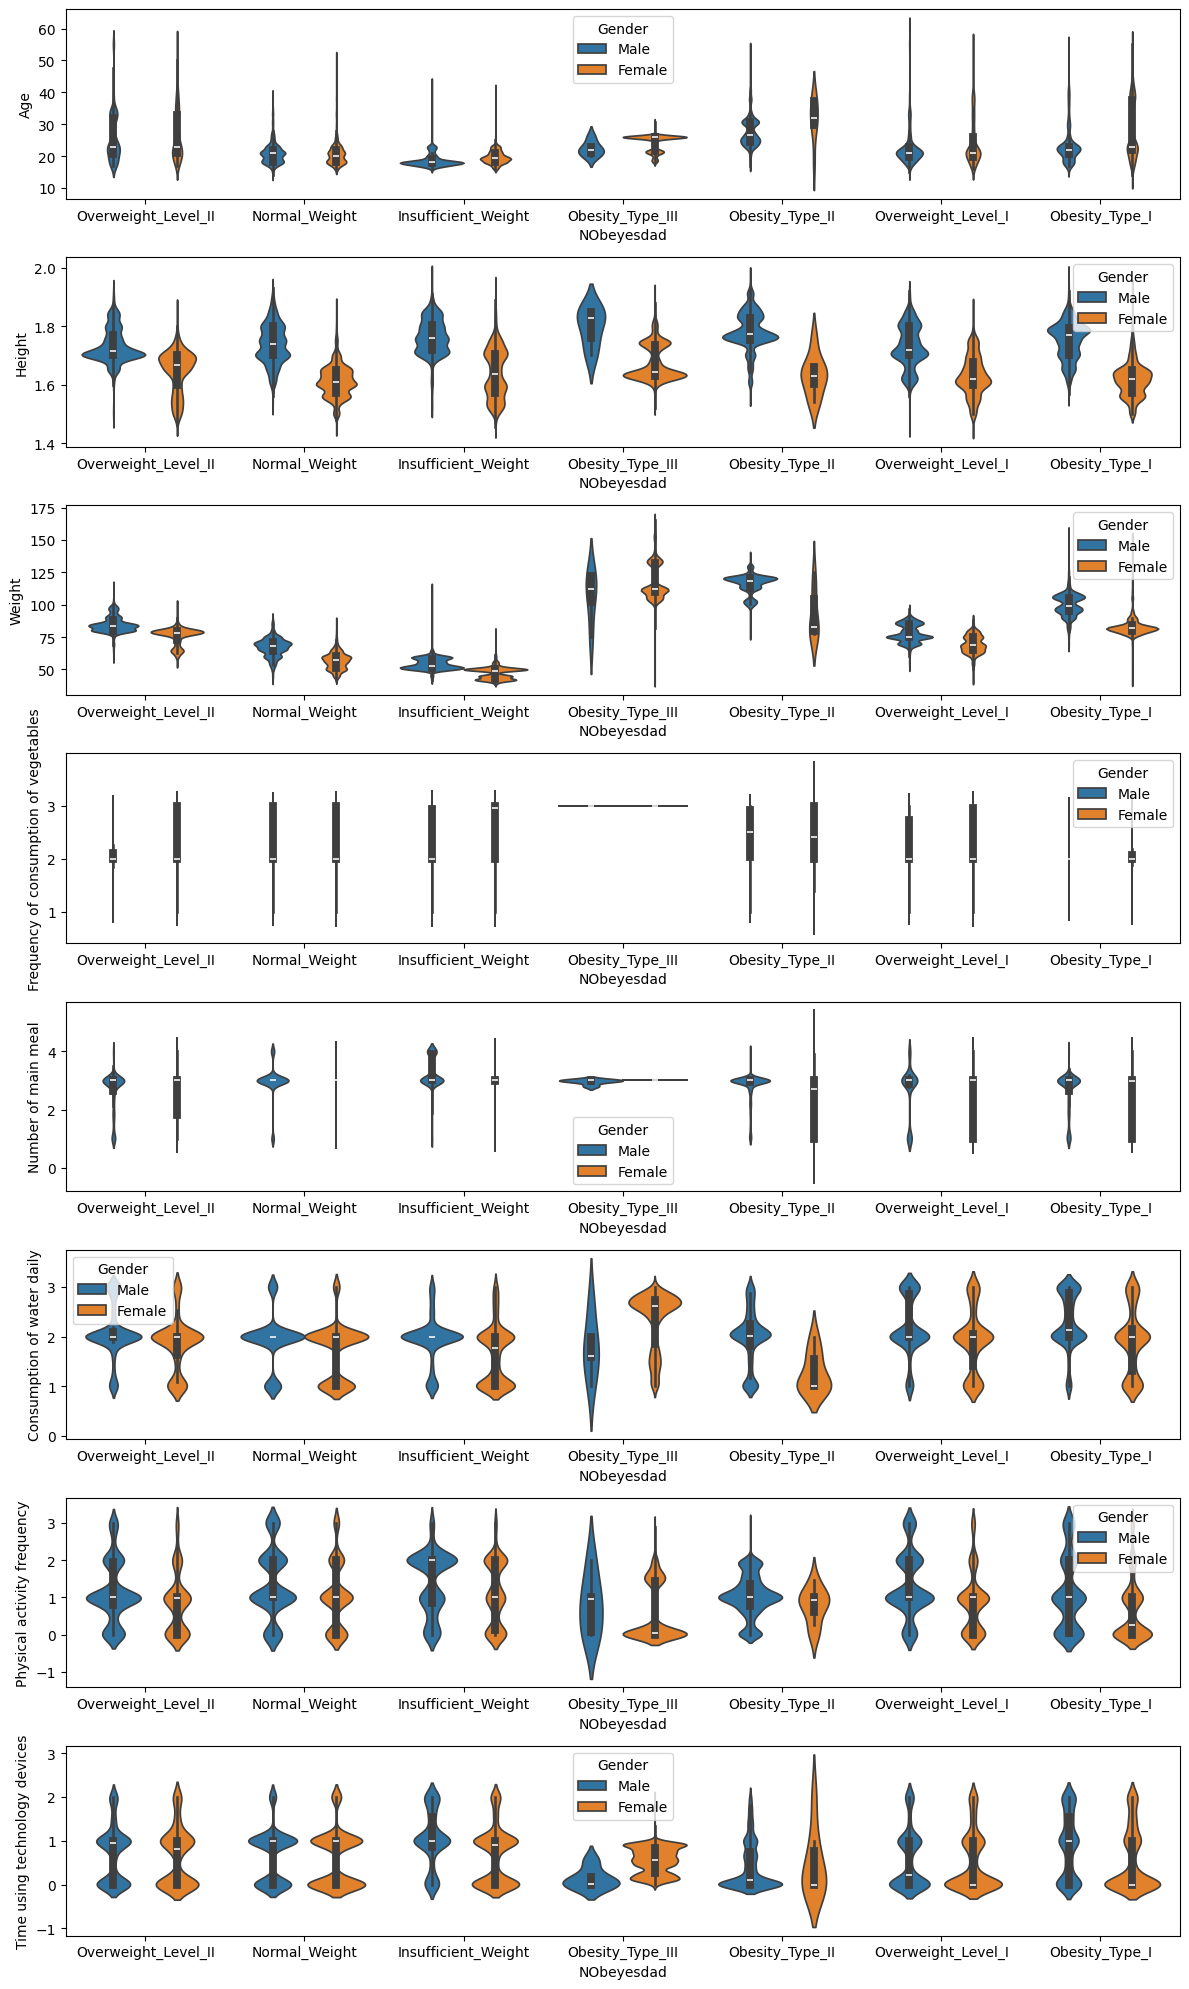

In [ ]:
fig,axs = plt.subplots(len(raw_num_cols),1,figsize=(12,len(raw_num_cols)*2.5),sharex=False)
for i, col in enumerate(raw_num_cols):
    sns.violinplot(x=TARGET, y=col,hue="Gender", data=train,ax = axs[i], split=False)
    if col in full_form.keys():
        axs[i].set_ylabel(full_form[col])

plt.tight_layout()
plt.show()

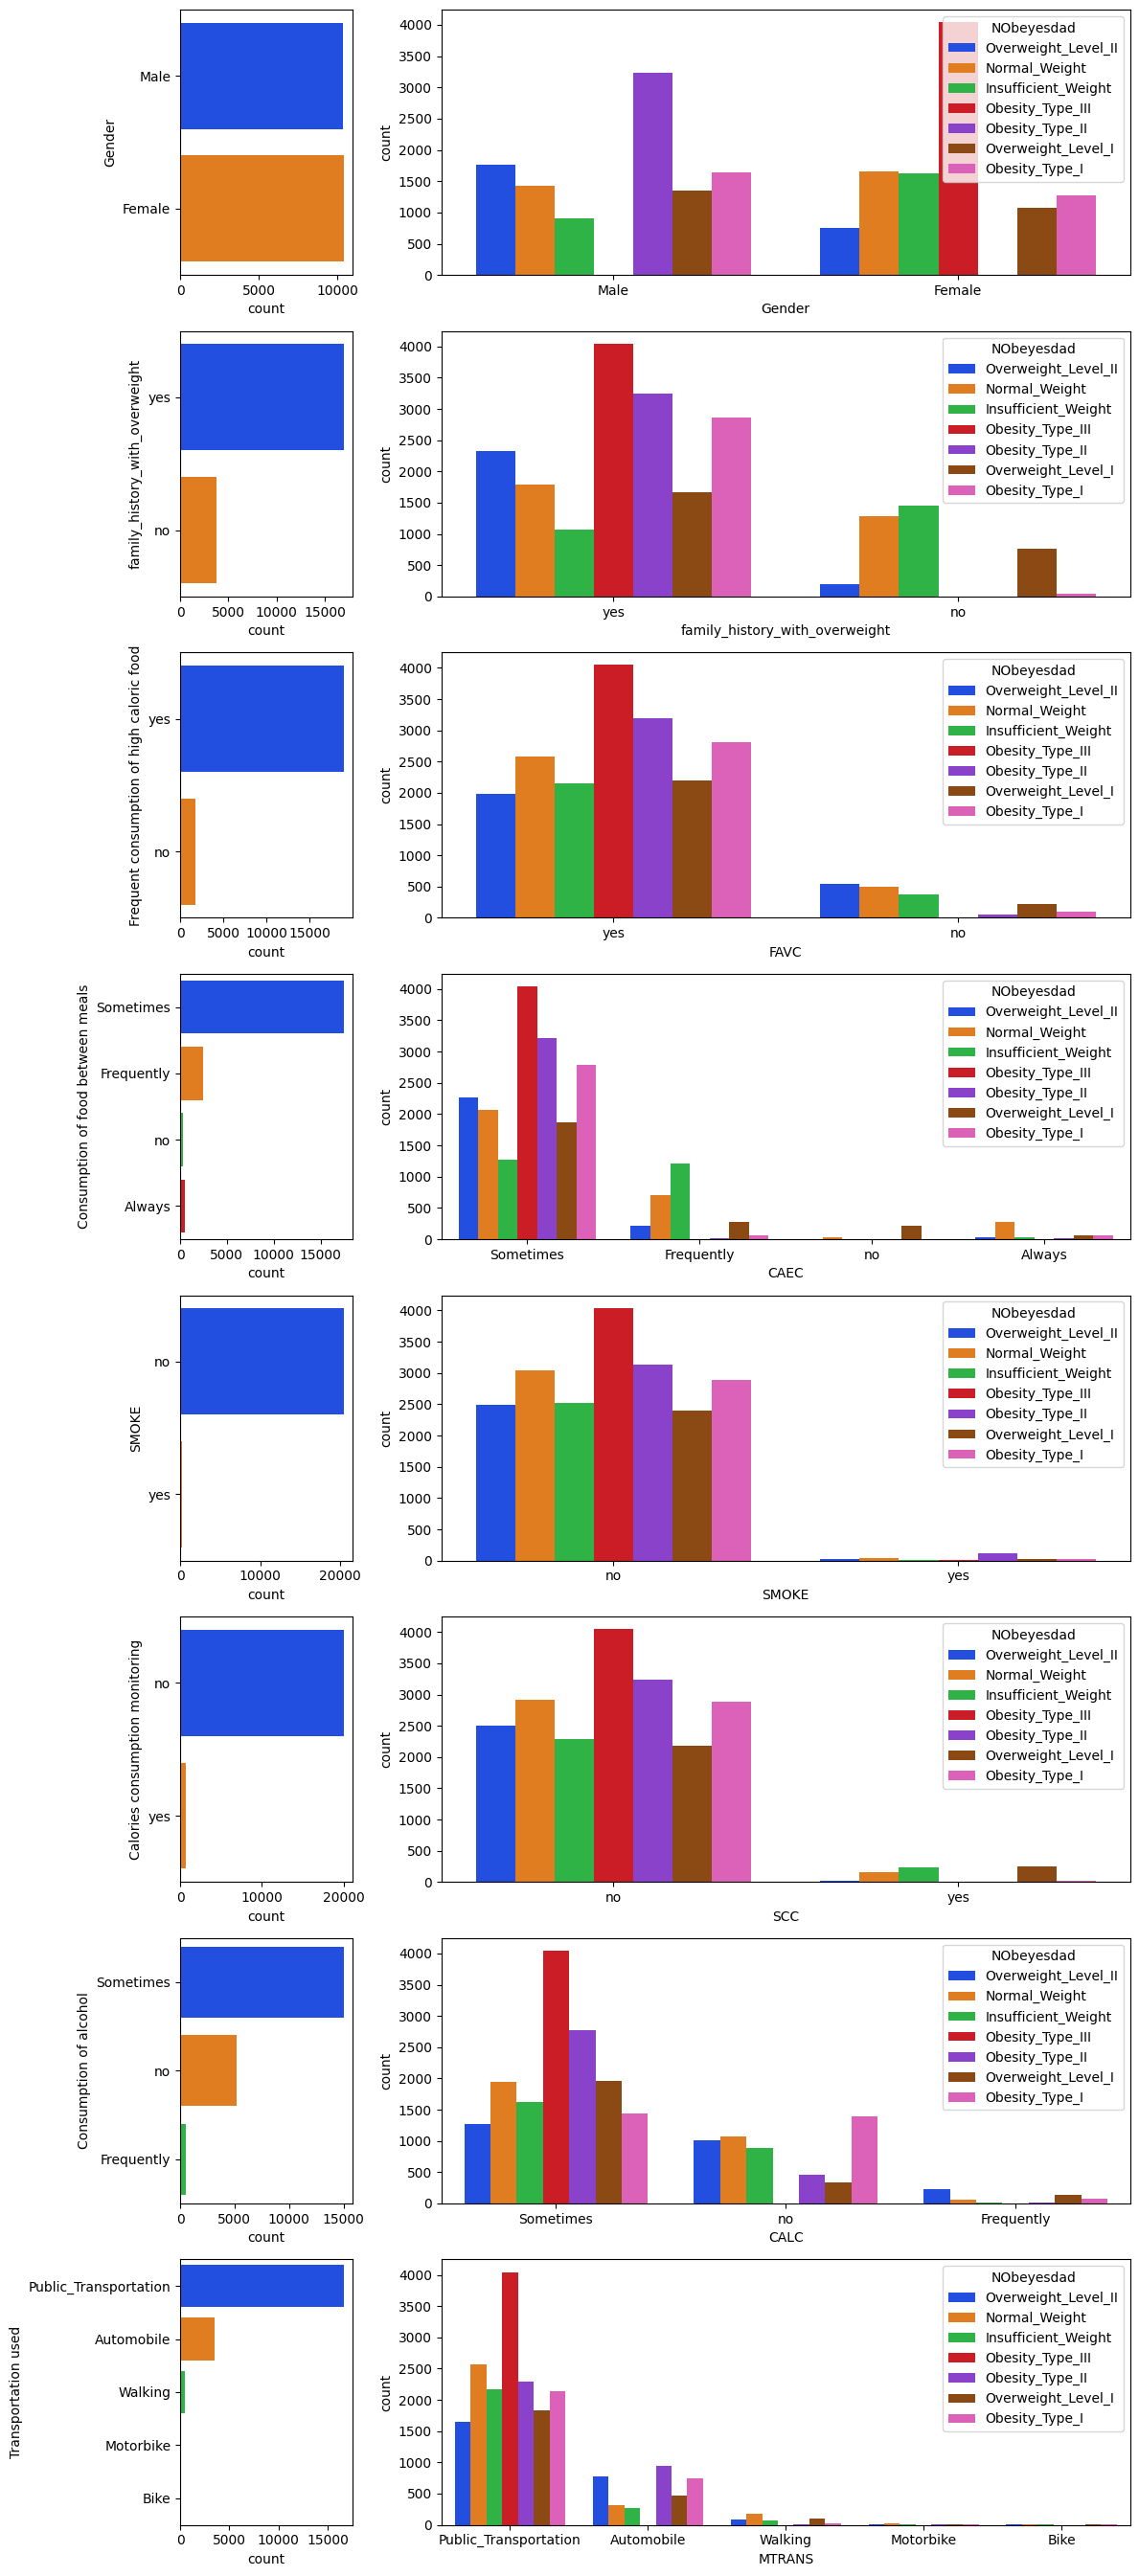

In [ ]:
_,axs = plt.subplots(int(len(raw_cat_cols)-1),2,figsize=(12,len(raw_cat_cols)*3),width_ratios=[1, 4])
for i,col in enumerate(raw_cat_cols[1:]):
    sns.countplot(y=col,data=train,palette="bright",ax=axs[i,0])
    sns.countplot(x=col,data=train,hue=TARGET,palette="bright",ax=axs[i,1])
    if col in full_form.keys():
        axs[i,0].set_ylabel(full_form[col])


plt.tight_layout()
plt.show()

<Axes: >

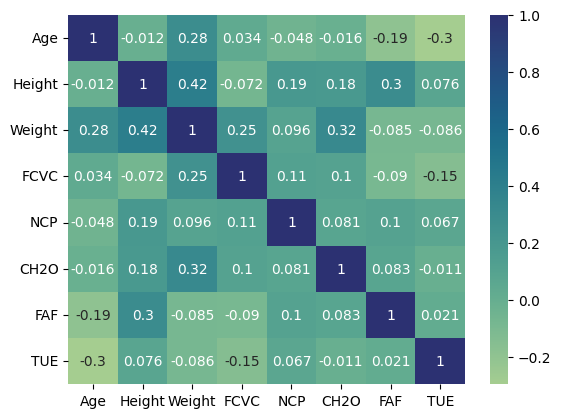

In [ ]:
tmp = train[raw_num_cols].corr("pearson")
sns.heatmap(tmp,annot=True,cmap ="crest")

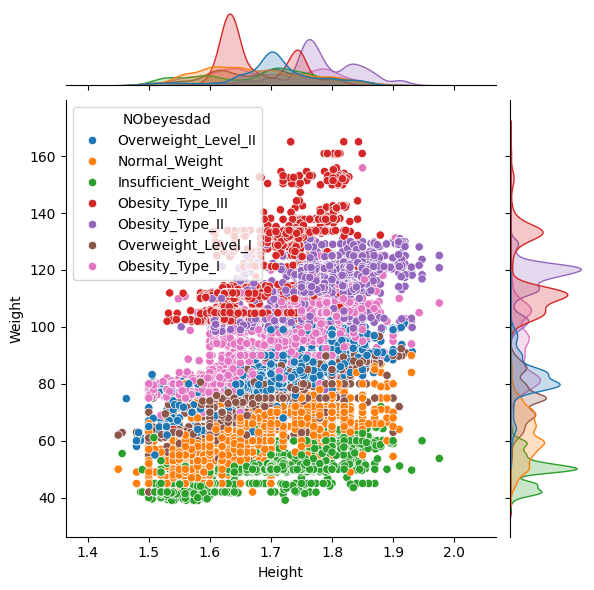

In [ ]:
sns.jointplot(data=train, x="Height", y="Weight", hue=TARGET,height=6)

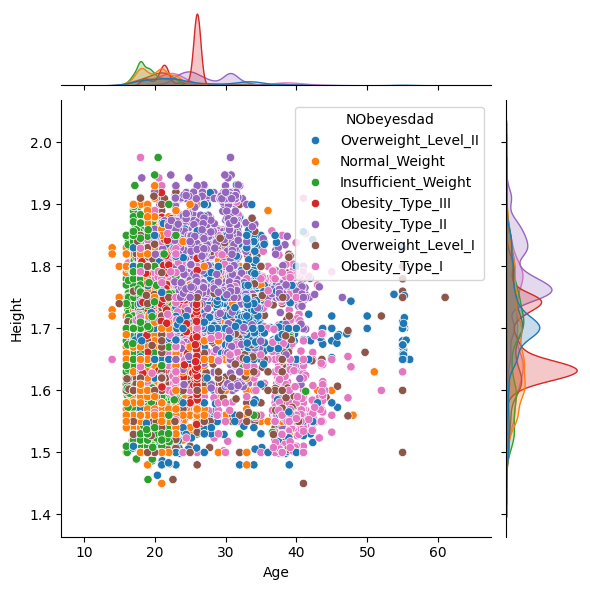

In [ ]:
sns.jointplot(data=train, x="Age", y="Height", hue=TARGET,height=6)

# PCA

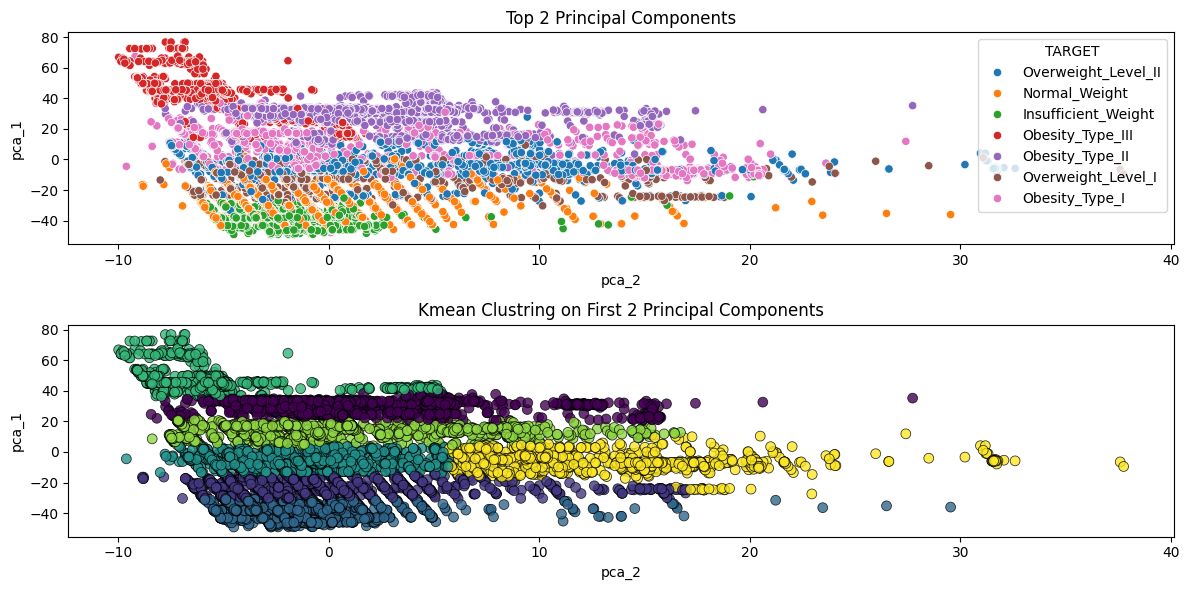

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#PCA
pca = PCA(n_components=2)
pca_top_2 = pca.fit_transform(train[raw_num_cols])

tmp = pd.DataFrame(data = pca_top_2, columns = ['pca_1','pca_2'])
tmp['TARGET'] = train[TARGET]

fig,axs = plt.subplots(2,1,figsize = (12,6))
sns.scatterplot(data=tmp, y="pca_1", x="pca_2", hue='TARGET',ax=axs[0])
axs[0].set_title("Top 2 Principal Components")

#KMeans
kmeans = KMeans(7,random_state=RANDOM_SEED)
kmeans.fit(tmp[['pca_1','pca_2']])
sns.scatterplot( y= tmp['pca_1'],x = tmp['pca_2'],c = kmeans.labels_,cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.8,ax = axs[1])
axs[1].set_title("Kmean Clustring on First 2 Principal Components")
plt.tight_layout()
plt.show()

In [ ]:
# In age_rounder, height_rounder func we multiply values
# by some value this sometimes improve model CV score
# In Extract features we combine features to get new features

def age_rounder(x):
    x_copy = x.copy()
    x_copy['Age'] = (x_copy['Age']*100).astype(np.uint16)
    return x_copy

def height_rounder(x):
    x_copy = x.copy()
    x_copy['Height'] = (x_copy['Height']*100).astype(np.uint16)
    return x_copy

def extract_features(x):
    x_copy = x.copy()
    x_copy['BMI'] = (x_copy['Weight']/x_copy['Height']**2)
#     x_copy['PseudoTarget'] = pd.cut(x_copy['BMI'],bins = [0,18.4,24.9,29,34.9,39.9,100],labels = [0,1,2,3,4,5],)
    return x_copy

def col_rounder(x):
    x_copy = x.copy()
    cols_to_round = ['FCVC',"NCP","CH2O","FAF","TUE"]
    for col in cols_to_round:
        x_copy[col] = round(x_copy[col])
        x_copy[col] = x_copy[col].astype('int')
    return x_copy

AgeRounder = FunctionTransformer(age_rounder)
HeightRounder = FunctionTransformer(height_rounder)
ExtractFeatures = FunctionTransformer(extract_features)
ColumnRounder = FunctionTransformer(col_rounder)


# Using FeatureDropper we can drop columns. This is
# important if we want to pass different set of features
# for different models

from sklearn.base import BaseEstimator, TransformerMixin
class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
    def fit(self,x,y):
        return self
    def transform(self, x):
        return x.drop(self.cols, axis = 1)

In [ ]:
# In cross_val_model we cross vaidate models using
# Stratified K-Fold.

# Encoding target values with int
target_mapping = {
                  'Insufficient_Weight':0,
                  'Normal_Weight':1,
                  'Overweight_Level_I':2,
                  'Overweight_Level_II':3,
                  'Obesity_Type_I':4,
                  'Obesity_Type_II':5 ,
                  'Obesity_Type_III':6
                  }

# Define a method for Cross validation here we are using StartifiedKFold
skf = StratifiedKFold(n_splits=n_splits)

def cross_val_model(estimators,cv = skf, verbose = True):
    '''
        estimators : pipeline consists preprocessing, encoder & model
        cv : Method for cross validation (default: StratifiedKfold)
        verbose : print train/valid score (yes/no)
    '''

    X = train.copy()
    y = X.pop(TARGET)

    y = y.map(target_mapping)
    test_predictions = np.zeros((len(test),7))
    valid_predictions = np.zeros((len(X),7))

    val_scores, train_scores = [],[]
    for fold, (train_ind, valid_ind) in enumerate(skf.split(X,y)):
        model = clone(estimators)
        #define train set
        X_train = X.iloc[train_ind]
        y_train = y.iloc[train_ind]
        #define valid set
        X_valid = X.iloc[valid_ind]
        y_valid = y.iloc[valid_ind]

        model.fit(X_train, y_train)
        if verbose:
            print("-" * 100)
            print(f"Fold: {fold}")
            print(f"Train Accuracy Score:-{accuracy_score(y_true=y_train,y_pred=model.predict(X_train))}")
            print(f"Valid Accuracy Score:-{accuracy_score(y_true=y_valid,y_pred=model.predict(X_valid))}")
            print("-" * 100)


        test_predictions += model.predict_proba(test)/cv.get_n_splits()
        valid_predictions[valid_ind] = model.predict_proba(X_valid)
        val_scores.append(accuracy_score(y_true=y_valid,y_pred=model.predict(X_valid)))
    if verbose:
        print(f"Average Mean Accuracy Score:- {np.array(val_scores).mean()}")
    return val_scores, valid_predictions, test_predictions

In [ ]:
#Combine Orignal & Synthetic Data

train.drop(['id'],axis = 1, inplace = True)
test_ids = test['id']
test.drop(['id'],axis = 1, inplace=True)

train = pd.concat([train,train_org],axis = 0)
train = train.drop_duplicates()
train.reset_index(drop=True, inplace=True)

# empty dataframe to store score, & train / test predictions.
score_list, oof_list, predict_list = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

### Random Forest model

In [ ]:
# Define Random Forest Model Pipeline

RFC = make_pipeline(
                        ExtractFeatures,
                        MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS']),
                       RandomForestClassifier(random_state=RANDOM_SEED)
                    )

In [ ]:
# Execute Random Forest Pipeline
val_scores,val_predictions,test_predictions = cross_val_model(RFC)

# Save train/test predictions in dataframes
for k,v in target_mapping.items():
    oof_list[f"rfc_{k}"] = val_predictions[:,v]

for k,v in target_mapping.items():
    predict_list[f"rfc_{k}"] = test_predictions[:,v]

----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-0.9999027237354086
Valid Accuracy Score:-0.8954048140043763
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-0.9999513618677043
Valid Accuracy Score:-0.9010940919037199
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-0.9999513618677043
Valid Accuracy Score:-0.8940919037199124
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy 

In [ ]:
# Define Optuna Function To Tune LGBM Model

def lgbm_objective(trial):
    params = {
        'learning_rate' : trial.suggest_float('learning_rate', .001, .1, log = True),
        'max_depth' : trial.suggest_int('max_depth', 2, 20),
        'subsample' : trial.suggest_float('subsample', .5, 1),
        'min_child_weight' : trial.suggest_float('min_child_weight', .1, 15, log = True),
        'reg_lambda' : trial.suggest_float('reg_lambda', .1, 20, log = True),
        'reg_alpha' : trial.suggest_float('reg_alpha', .1, 10, log = True),
        'n_estimators' : 1000,
        'random_state' : RANDOM_SEED,
        'device_type' : "gpu",
        'num_leaves': trial.suggest_int('num_leaves', 10, 1000),

        #'boosting_type' : 'dart',
    }

    optuna_model = make_pipeline(
                                 ExtractFeatures,
                                 MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS']),
                                LGBMClassifier(**params,verbose=-1)
                                )
    val_scores, _, _ = cross_val_model(optuna_model,verbose = False)
    return np.array(val_scores).mean()

lgbm_study = optuna.create_study(direction = 'maximize',study_name="LGBM")

[I 2024-02-25 07:33:09,431] A new study created in memory with name: LGBM


In [ ]:
# Execute LGBM Tuning, To Tune set `TUNE` to True (it will take a long time)
TUNE = False

warnings.filterwarnings("ignore")
if TUNE:
    lgbm_study.optimize(lgbm_objective, 50)

In [ ]:
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = train.select_dtypes(include=['object']).columns.tolist()
categorical_columns.remove('NObeyesdad')

In [ ]:
# Here we defined LGBM Pipeline
# Where we use One_Hot_Encoder, for categorical encoding
# standard scaler for numerical column scaling


params = {'learning_rate': 0.04325905707439143, 'max_depth': 4,
          'subsample': 0.6115083405793659, 'min_child_weight': 0.43633356137010687,
          'reg_lambda': 9.231766981717822, 'reg_alpha': 1.875987414096491, 'num_leaves': 373,
          'n_estimators' : 1000,'random_state' : RANDOM_SEED, 'device_type' : "gpu",
         }

best_params = {
    "objective": "multiclass",          # Objective function for the model
    "metric": "multi_logloss",          # Evaluation metric
    "verbosity": -1,                    # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",            # Gradient boosting type
    "random_state": 42,       # Random state for reproducibility
    "num_class": 7,                     # Number of classes in the dataset
    'learning_rate': 0.030962211546832760,  # Learning rate for gradient boosting
    'n_estimators': 500,                # Number of boosting iterations
    'lambda_l1': 0.009667446568254372,  # L1 regularization term
    'lambda_l2': 0.04018641437301800,   # L2 regularization term
    'max_depth': 10,                    # Maximum depth of the trees
    'colsample_bytree': 0.40977129346872643,  # Fraction of features to consider for each tree
    'subsample': 0.9535797422450176,    # Fraction of samples to consider for each boosting iteration
    'min_child_samples': 26             # Minimum number of data needed in a leaf
}

lgbm = make_pipeline(
                        ColumnTransformer(
                        transformers=[('num', StandardScaler(), numerical_columns),
                                  ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_columns)]),
                        LGBMClassifier(**best_params,verbose=-1)
                    )

In [ ]:
# Train LGBM Model

val_scores,val_predictions,test_predictions = cross_val_model(lgbm)

for k,v in target_mapping.items():
    oof_list[f"lgbm_{k}"] = val_predictions[:,v]

for k,v in target_mapping.items():
    predict_list[f"lgbm_{k}"] = test_predictions[:,v]


----------------------------------------------------------------------------------------------------
Fold: 0
Train Accuracy Score:-0.9771400778210116
Valid Accuracy Score:-0.9089715536105033
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 1
Train Accuracy Score:-0.9767509727626459
Valid Accuracy Score:-0.9076586433260394
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 2
Train Accuracy Score:-0.9776264591439688
Valid Accuracy Score:-0.9059080962800875
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Fold: 3
Train Accuracy 

In [ ]:
# Optuna study for XGB Model
def xgb_objective(trial):
    params = {
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'gamma' : trial.suggest_float('gamma', 1e-9, 1.0),
        'subsample': trial.suggest_float('subsample', 0.25, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.25, 1.0),
        'max_depth': trial.suggest_int('max_depth', 0, 24),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
    }

    params['booster'] = 'gbtree'
    params['objective'] = 'multi:softmax'
    params["device"] = "cuda"
    params["verbosity"] = 0
    params['tree_method'] = "gpu_hist"


    optuna_model = make_pipeline(
                    MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS']),
                    XGBClassifier(**params,seed=RANDOM_SEED)
                   )

    val_scores, _, _ = cross_val_model(optuna_model,verbose = False)
    return np.array(val_scores).mean()

xgb_study = optuna.create_study(direction = 'maximize')

[I 2024-02-25 07:38:11,219] A new study created in memory with name: no-name-8c209c1f-b7e8-423d-a06a-d203cef2cc49


In [ ]:
# Tune using Optuna
TUNE = False
if TUNE:
    xgb_study.optimize(xgb_objective, 50)

In [ ]:
# XGB Pipeline

params = {
    'n_estimators': 1312,
    'learning_rate': 0.018279520260162645,
    'gamma': 0.0024196354156454324,
    'reg_alpha': 0.9025931173755949,
    'reg_lambda': 0.06835667255875388,
    'max_depth': 5,
    'min_child_weight': 5,
    'subsample': 0.883274050086088,
    'colsample_bytree': 0.6579828557036317
}
# {'eta': 0.018387615982905264, 'max_depth': 29, 'subsample': 0.8149303101087905, 'colsample_bytree': 0.26750463604831476, 'min_child_weight': 0.5292380065098192, 'reg_lambda': 0.18952063379457604, 'reg_alpha': 0.7201451827004944}

params = {'grow_policy': 'depthwise', 'n_estimators': 690,
               'learning_rate': 0.31829021594473056, 'gamma': 0.6061120644431842,
               'subsample': 0.9032243794829076, 'colsample_bytree': 0.44474031945048287,
               'max_depth': 10, 'min_child_weight': 22, 'reg_lambda': 4.42638097284094,
               'reg_alpha': 5.927900973354344e-07,'seed':RANDOM_SEED}

best_params = {'grow_policy': 'depthwise', 'n_estimators': 982,
               'learning_rate': 0.050053726931263504, 'gamma': 0.5354391952653927,
               'subsample': 0.7060590452456204, 'colsample_bytree': 0.37939433412123275,
               'max_depth': 23, 'min_child_weight': 21, 'reg_lambda': 9.150224029846654e-08,
               'reg_alpha': 5.671063656994295e-08}
best_params['booster'] = 'gbtree'
best_params['objective'] = 'multi:softmax'
best_params["device"] = "cuda"
best_params["verbosity"] = 0
best_params['tree_method'] = "gpu_hist"

XGB = make_pipeline(
                    MEstimateEncoder(cols=['Gender','family_history_with_overweight','FAVC','CAEC',
                                           'SMOKE','SCC','CALC','MTRANS']),
                    XGBClassifier(**best_params,seed=RANDOM_SEED)
                   )

In [ ]:
val_scores,val_predictions,test_predictions = cross_val_model(XGB)

for k,v in target_mapping .items():
    oof_list[f"xgb_{k}"] = val_predictions[:,v]

for k,v in target_mapping.items():
    predict_list[f"xgb_{k}"] = test_predictions[:,v]

In [ ]:
# Optuna Function For Catboost Model
def cat_objective(trial):

    params = {

        'iterations': 1000,  # High number of estimators
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'random_seed': RANDOM_SEED,
        'verbose': False,
        'task_type':"GPU"
    }

    cat_features = ['Gender','family_history_with_overweight','FAVC','FCVC','NCP',
                'CAEC','SMOKE','CH2O','SCC','FAF','TUE','CALC','MTRANS']
    optuna_model = make_pipeline(
                        ExtractFeatures,
#                         AgeRounder,
#                         HeightRounder,
#                         MEstimateEncoder(cols = raw_cat_cols),
                        CatBoostClassifier(**params,cat_features=cat_features)
                        )
    val_scores,_,_ = cross_val_model(optuna_model,verbose = False)
    return np.array(val_scores).mean()

cat_study = optuna.create_study(direction = 'maximize')

[I 2024-02-25 07:38:44,540] A new study created in memory with name: no-name-beaae6a7-7ca0-4850-93a2-444a19165f32


In [ ]:
params = {'learning_rate': 0.13762007048684638, 'depth': 5,
          'l2_leaf_reg': 5.285199432056192, 'bagging_temperature': 0.6029582154263095,
         'random_seed': RANDOM_SEED,
        'verbose': False,
        'task_type':"GPU",
         'iterations':1000}


In [ ]:
# Train Catboost Model
val_scores,val_predictions,test_predictions = cross_val_model(CB)
for k,v in target_mapping.items():
    oof_list[f"cat_{k}"] = val_predictions[:,v]

for k,v in target_mapping.items():
    predict_list[f"cat_{k}"] = test_predictions[:,v]

In [ ]:
# skf = StratifiedKFold(n_splits=5)
weights = {"rfc_":0,
           "lgbm_":3,
           "xgb_":1,
           "cat_":0}
tmp = oof_list.copy()
for k,v in target_mapping.items():
    tmp[f"{k}"] = (weights['rfc_']*tmp[f"rfc_{k}"] +
              weights['lgbm_']*tmp[f"lgbm_{k}"]+
              weights['xgb_']*tmp[f"xgb_{k}"]+
              weights['cat_']*tmp[f"cat_{k}"])
tmp['pred'] = tmp[target_mapping.keys()].idxmax(axis = 1)
tmp['label'] = train[TARGET]
print(f"Ensemble Accuracy Scoe: {accuracy_score(train[TARGET],tmp['pred'])}")

cm = confusion_matrix(y_true = tmp['label'].map(target_mapping),
                      y_pred = tmp['pred'].map(target_mapping),
                     normalize='true')

cm = cm.round(2)
plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = target_mapping.keys())
disp.plot(xticks_rotation=50)
plt.tight_layout()
plt.show()

In [ ]:
weights

{'rfc_': 0, 'lgbm_': 3, 'xgb_': 1, 'cat_': 0}

In [ ]:
for k,v in target_mapping.items():
    predict_list[f"{k}"] = (weights['rfc_']*predict_list[f"rfc_{k}"]+
                            weights['lgbm_']*predict_list[f"lgbm_{k}"])

final_pred = predict_list[target_mapping.keys()].idxmax(axis = 1)

sample_sub[TARGET] = final_pred
sample_sub.to_csv("submission.csv",index=False)
sample_sub

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III
...,...,...
13835,34593,Overweight_Level_II
13836,34594,Normal_Weight
13837,34595,Insufficient_Weight
13838,34596,Normal_Weight


# Another approach

In [ ]:
# Data Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
# linear algebra & data processing
import numpy as np
import pandas as pd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)

#Import Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Import Accuracy Metrics
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Import Classifiers
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

# Import Model Selection
from sklearn.model_selection import train_test_split

# Get CSS root file from github
# You can create various CSS templates and load it into your notebooks
!wget https://raw.githubusercontent.com/IamDal/IamDal/main/Neutral.css -O Neutral.css -q

# Load CSS file
from IPython.core.display import HTML
with open('./Neutral.css', 'r') as file:
    custom_css = file.read()
HTML(custom_css)

In [ ]:
# Define Palette
palette = ['#8D7B68', '#F1DEC9', '#C8B6A6', '#A4907C',
           '#BBD6B8', '#DBE4C6', '#AEC2B6', '#94AF9F']

# Create a dictionary of RC values for matplotlib
rc = {
    "axes.facecolor": "#FFFFFF",
    "figure.facecolor": "#FFFFFF",
    "axes.edgecolor": "#C8B6A6",
    "grid.color": "#C8B6A6",
    "font.family": "monospace",
    "font.monospace" : "Computer Modern Typewriter",
    "axes.labelcolor": "#8D7B68",
    "xtick.color": "#8D7B68",
    "ytick.color": "#8D7B68",
    "grid.alpha": 0.5,
    "xtick.labelsize" : 10,
    "ytick.labelsize" : 10,
    "axes.titlesize" : 12,
    "axes.labelsize" : 9,
    "legend.fontsize" : 6,
    "legend.title_fontsize" : 8,
    "axes.titlecolor" : "#8D7B68",
    "figure.raise_window" : True,
    "text.color" : "#8D7B68"
}

# Set RC values
sns.set(rc=rc)

from colorama import Style, Fore
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
mgt = Style.BRIGHT + Fore.MAGENTA
gld = Style.BRIGHT + Fore.YELLOW
res = Style.RESET_ALL

In [ ]:
def summary(df):
    """
    Displays a dataframe and it's shape as summary
    df = takes a dataframe as input
    returns the summary of the dataframe. ie:
    shape, data types, count,number of missing values,
    percentage of missing values and number of unique
    values
    """
    # Displays shape of Dataframe
    print(f"DataFrame summary:\nNumber of DataFrame columns:\
          {df.shape[1]}\nNumber of DataFrame entries:{df.shape[0]}")
    print("-"*40)

    # Creates  a new dataframe
    summary = pd.DataFrame()

    # Add a column for datatypes
    summary['Dtype'] = df.dtypes

    # Add a column for count
    summary['Count'] = df.count()

    # Add a column for count of missing values
    summary['MissingCount'] = df.isnull().sum()

    # Add a column for missing percentage
    summary['Missing%%'] = (df.isnull().sum()/traindf.shape[0])*100

    # Add a column for count of unique values
    summary['UniqueValues'] = df.nunique()

    # Return Dataframe of summary
    return summary


def feature_importance(models, df, ytest, Xtest):
    """
    It takes a lis of models, Dataframe and Test data as input
    and displays a horizontal bar chart of the features sorted by
    importance values of the imported model. It also displays
    a confusion matrix of the predicted results
    """

    # Set figure and axes
    fig, axes = plt.subplots(len(models),2,figsize=(10*len(models),10*len(models)),sharey=False,
                            gridspec_kw = {'hspace': 0.4, 'wspace': 0.5})

    # Iterate over the list of models
    for i,model in enumerate(models):
        y_pred = model.predict(Xtest)

        # Get the name of the model
        name = type(model.named_steps['model']).__name__

        # Print Classification Report
        print(name)
        print(classification_report(ytest, y_pred))

        # Get the feature importance values
        feature_value = model.named_steps['model'].feature_importances_

        # Get the name of features

        if hasattr(model.named_steps['preprocessor'], 'get_feature_names_out'):
            features = model.named_steps['preprocessor'].get_feature_names_out(df.columns)

        # Create Dataframe of important feature
        feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_value})\
                                                .sort_values(by='Importance', ascending=False)

        # Plot Features
        ax = axes[i,0]
        sns.barplot(feature_importance_df,x='Importance',y='Feature',palette = palette,ax=ax)
        plt.suptitle(f'Feature Importance',y=.92)
        ax.set_title(f'{name} Feature Importance')

        # Annotate barplot
        for p in ax.patches:
            ax.annotate(f'{p.get_width():.2f}', (p.get_width(), p.get_y() + p.get_height() / 20),
                        ha='center', va='center', xytext=(18, -12), textcoords='offset points')

        # Plot Confusion Matrix
        ax = axes[i,1]
        ytest_labels = encoder.inverse_transform(ytest)
        y_pred_labels = encoder.inverse_transform(y_pred)
        labels = list(pd.Series(ytest_labels).unique())
        cm = confusion_matrix(ytest_labels, y_pred_labels)
        sns.heatmap(cm, annot=True, ax = ax,fmt='0g',cmap='YlOrBr')
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.set_yticklabels(labels, rotation=0)

        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title(f'{name} Confusion Matrix')

    # display chart
    plt.tight_layout()
    plt.show()


# Function to get a list of categorical and numerical columns
def get_catnum(df):
    """
    Takes a dataframe(df) and dseparates
    categorical features and numerical
    features and returns a list for each set.
    """
    # Create a dataframe of the unique value count
    condition = pd.DataFrame(df.nunique(),columns=['Unique'])

    # Drop features with unique count less than 10
    categorical_features = list(condition[condition < 10].dropna().index)

    # Drop categorical features from total features
    numeric_features = list(set(df.select_dtypes(['int64','float64']).columns) - set(categorical_features))

    # Return list of categorical and numerical features
    return categorical_features, numeric_features


# Function to plot numercal features against categorical features
def distribution_view(df,numeric,target):

    # Get the number of numeric columns
    features_num = len(numeric)

    # Set figure and axes
    fig, axes = plt.subplots(features_num, 3,figsize=(16, features_num * 3),
                             gridspec_kw = {'hspace': 0.3, 'wspace': 0.6,
                                            'width_ratios': [0.80, 0.80, 0.50]})

    # Iterate over the list of numeric features
    for i, num in enumerate(numeric):

        # Set axes and creates a KDE plot
        ax = axes[i,0]
        sns.kdeplot(df, x=num, hue=target, palette=palette,
                    shade=True, ax=ax)

        # Set axes and creates a violin plot
        ax = axes[i,1]
        sns.stripplot(df, x=num, palette=palette, ax=ax, y='NObeyesdad',
                       hue=target,dodge=True)


        # Set axes and creates a box plot
        ax = axes[i,2]
        sns.boxplot(df, x=num, y=target, palette=palette,
                    showfliers=False, notch=False, ax=ax, orient ='h')

    # Set title and show plot
    plt.suptitle(f'Distribution Charts of Numerical Features with {target}',y=.9)
    plt.tight_layout()
    plt.show()


# Function to plot numercal features against numerical features
def contiuos_view(df,numeric,target):

    # Get the number of numeric features
    number_of_features = len(numeric)

    # Set figure and axes
    fig, axes = plt.subplots(1,number_of_features ,figsize = (number_of_features * 4,3),
                             gridspec_kw = {'hspace': 0.4, 'wspace': 0.4})

    # Iterate over the list of numeric features
    for i, num in enumerate(numeric):

        # Set axes and creates a scatterplot
        ax = axes[i]
        sns.scatterplot(df, y=num, x=target,
                        palette=palette,
                        ax=ax, hue='NObeyesdad')

    # Set title and show plot
    plt.suptitle(f'Distribution Charts of Numerical Features with {target}',y=.95)
    plt.tight_layout()
    plt.show()


def side_by_side(*args):
    """
    Displays dataframes side by side
    '('Ideally to be used in tandem with
    the summary function')'
    the other dataframe columns will be
    renamed.
    """
    # Returns error if less than two dataframes are passed
    if len(args) < 2:
        raise ValueError("At least two DataFrames are required for concatenation.")

    # Initialize new dataframe with the first argument
    concatenated_df = summary(args[0])

    # Iterate over the elements of the arguments
    for i, arg in enumerate(args[1:]):
        summ = summary(arg)

        # Rename columns in dataframe
        summ.columns = 'DF'+ f'{i+1}_' +summ.columns

        # Concatenate dataframes
        concatenated_df = pd.concat([concatenated_df,summ], axis = 1)
    return concatenated_df

In [ ]:
# Read CSV files to DataFrames
traindf = pd.read_csv('/content/playground-series-s4e2/train.csv')
testdf = pd.read_csv('/content/playground-series-s4e2/test.csv')
train_extra = pd.read_csv('/content/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv')

In [ ]:
# Display data sets
space = 60*'*'
display(f'{space}Train Dataframe 1{space}',traindf.head(),
        f'{space}Train Dataframe 2{space}',train_extra.head(),
        f'{space}Test Dataframe{space}',testdf.head())

In [ ]:
# Display a concatonated view of the dataframes' summaries
side_by_side(traindf,testdf,train_extra)\
    .style.background_gradient(cmap='YlOrBr')

In [ ]:
# Rename inconsistent columns
train_extra = train_extra.reset_index(names='id')
train_extra['id'] = train_extra['id'] + traindf.shape[0]

# Concatenate Dataframes
traindf = pd.concat([traindf,train_extra],ignore_index=True)

# Display summary of new dataframe
summary(traindf).style.background_gradient(cmap='YlOrBr')

In [ ]:
encoder= LabelEncoder()
train_gender = encoder.fit_transform(traindf['Gender'])
test_gender = encoder.fit_transform(testdf['Gender'])

traindf['BMI'] = traindf['Weight']/traindf['Height']**2
testdf['BMI'] = testdf['Weight']/testdf['Height']**2

traindf['BFP'] = (1.2*traindf['BMI']) + (0.23*traindf['Age']) - ((train_gender * 1) + (train_gender + 1)) * 5.4
testdf['BFP'] = (1.2*testdf['BMI']) + (0.23*testdf['Age']) - ((test_gender * 1) + (test_gender + 1)) * 5.4

display(traindf.head())
display(testdf.head())